In [123]:
# Imports

import numpy as np
import glob

import statistics as stats
import librosa

from scipy.io import wavfile
from scipy.fft import fft
from scipy.stats import skew, kurtosis, mode, iqr

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn import svm, preprocessing

FS_RATE = 22050
SIGNAL_LEN = 66150

In [3]:
def read_wav_file(file_name):
    return wavfile.read(file_name)[1]

In [4]:
# Read files and labels
signals = []
labels = []

with open('./data/labels.csv') as labels_file:
    labels_raw = dict([line.strip().split(',') for line in labels_file.readlines()[1:]])

    for file_name in glob.glob('./data/audio/*.wav'):
        signals.append(read_wav_file(file_name))
        labels.append(labels_raw[file_name.split('\\')[1]])

In [80]:
# Convert to np array
raw_data = np.array(signals)
labels = np.array(labels)

In [37]:
def extract_features(signal_data):
    signal_fft = np.abs(fft(signal_data))[:SIGNAL_LEN // 2]
    
    # Simple feature extraction
    signal_features = [

        # Base stats
        stats.median(signal_data),
        stats.median_low(signal_data),
        stats.median_high(signal_data),
        stats.median_grouped(signal_data),
        stats.pstdev(signal_data),
        stats.pvariance(signal_data),
        stats.stdev(signal_data),
        stats.variance(signal_data),

        # Advanced stats
        skew(signal_data),
        kurtosis(signal_data),
        iqr(signal_data),

        # Energy and root mean square energy
        np.sum(signal_data**2),
        *librosa.feature.rms(y=signal_data)[0],

        # Tempo and zero crossings
        librosa.beat.tempo(y=signal_data)[0],
        sum(librosa.zero_crossings(y=signal_data, pad=False)),
        
        # Spectral features
        *librosa.feature.spectral_bandwidth(y=signal_data)[0],
        *librosa.feature.spectral_contrast(y=signal_data)[0],
        *librosa.feature.spectral_flatness(y=signal_data)[0],
        *librosa.feature.spectral_rolloff(y=signal_data)[0],

        # FFT features
        stats.median(signal_fft),
        stats.median_low(signal_fft),
        stats.median_high(signal_fft),
        stats.median_grouped(signal_fft)
    ]


    return signal_features

In [77]:
def extract_features_unsupervised(signal_data):
    signal_fft = np.abs(fft(signal_data))[:SIGNAL_LEN // 2]

    # Simple feature extraction
    signal_features = [

        # Base stats
        stats.median(signal_data),
        stats.median_low(signal_data),
        stats.median_high(signal_data),
        stats.median_grouped(signal_data),
        stats.pstdev(signal_data),
        stats.pvariance(signal_data),
        stats.stdev(signal_data),
        stats.variance(signal_data),

        # Advanced stats
        skew(signal_data),
        kurtosis(signal_data),
        iqr(signal_data),

        # Energy and root mean square energy
        np.sum(signal_data**2),

        # Tempo and zero crossings
        librosa.beat.tempo(y=signal_data)[0],
        sum(librosa.zero_crossings(y=signal_data, pad=False)),

        # FFT features
        stats.median(signal_fft),
        stats.median_low(signal_fft),
        stats.median_high(signal_fft),
        stats.median_grouped(signal_fft)
    ]

    return signal_features

In [38]:
# Apply feature extraction
data = np.array([extract_features(signal) for signal in raw_data])

In [ ]:
data_unsupervised = np.array([extract_features_unsupervised(signal) for signal in raw_data])

##### SVM

In [94]:
# Normalise the data set
scaler = preprocessing.StandardScaler()
_ = scaler.fit(data)

In [96]:
data_scaled = scaler.transform(data)

In [119]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.2, random_state=42)

In [120]:
svm_classifier = svm.SVC()
_ = svm_classifier.fit(X_train, y_train)

In [121]:
score = svm_classifier.score(X_test, y_test)
print(score)

0.6747787610619469


##### K-Means

In [104]:
# Create model and fit_predict for different number of clusters
scores = []

for i in range(2, 10):
    k_means = KMeans(n_clusters=i, random_state=0, n_init='auto')
    predicts = k_means.fit_predict(data_unsupervised)

    # Calculkate silhoutette_score
    score = silhouette_score(data_unsupervised, predicts)
    scores.append(score)

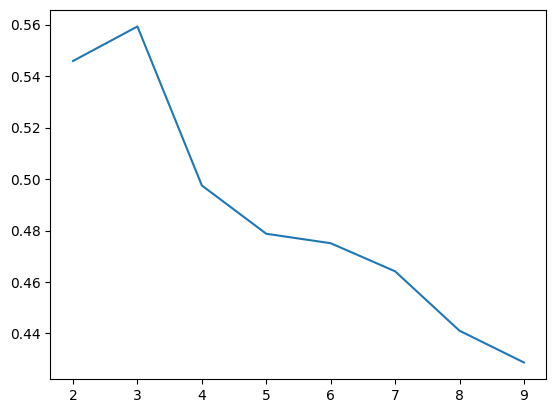

In [105]:
# Plot silhouette scores
plt.plot(list(range(2, 10)), scores)
plt.show()

In [106]:
# Create model and fit_predict for known number of clusters
k_means_true = KMeans(n_clusters=5, random_state=0, n_init='auto')
predicts = k_means_true.fit_predict(data_unsupervised)

# Calculkate silhoutette_score
score = silhouette_score(data_unsupervised, predicts)
print(score)

0.47874175785650874


In [137]:
parameters = {
    'max_iter': [300, 400, 500],
    'tol': [0.0001, 0.0002, 0.0003],
    'algorithm': ['lloyd', 'elkan']
}

best_score = -1
best_params = {}

# Hand-made grid search
for max_iter in parameters['max_iter']:
    for tol in parameters['tol']:
        for algorithm in parameters['algorithm']:
            k_means_grid = KMeans(n_clusters=5, random_state=0, n_init='auto', max_iter=max_iter, tol=tol, algorithm=algorithm)
            predicts = k_means_grid.fit_predict(data_unsupervised)

            if silhouette_score(data_unsupervised, predicts) > best_score:
                best_score = silhouette_score(data_unsupervised, predicts)
                best_params['max_iter'] = max_iter
                best_params['tol'] = tol
                best_params['algorithm'] = algorithm

print(f'Greates hyperparameters: max_iter = {best_params["max_iter"]}, tol = {best_params["tol"]}, algorithm = {best_params["algorithm"]}. Score = {best_score}')

Greates hyperparameters: max_iter = 300, tol = 0.0003, algorithm = lloyd. Score = 0.48163588814344216


#### Agglomerative

In [112]:
# Create model and fit_predict for different number of clusters
scores = []

for i in range(2, 10):
    agglomerative = AgglomerativeClustering(n_clusters=i)
    predicts = agglomerative.fit_predict(data_unsupervised)

    # Calculkate silhoutette_score
    score = silhouette_score(data_unsupervised, predicts)
    scores.append(score)

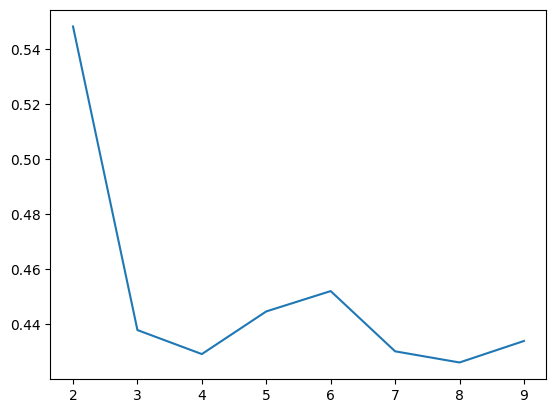

In [108]:
# Plot silhouette scores
plt.plot(list(range(2, 10)), scores)
plt.show()

In [114]:
# Create model and fit_predict for known number of clusters
agglomerative_true = AgglomerativeClustering(n_clusters=5)
predicts = agglomerative_true.fit_predict(data_unsupervised)

# Calculkate silhoutette_score
score = silhouette_score(data_unsupervised, predicts)
print(score)

0.44473479201447474


In [140]:
parameters = {
    'linkage': ['ward', 'complete', 'average', 'single'],
}

best_score = -1
best_params = {}

# Hand-made grid search
for linkage in parameters['linkage']:
    agglomerative_grid = AgglomerativeClustering(n_clusters=5, linkage=linkage)
    predicts = agglomerative_grid.fit_predict(data_unsupervised)

    if silhouette_score(data_unsupervised, predicts) > best_score:
        best_score = silhouette_score(data_unsupervised, predicts)
        best_params['linkage'] = linkage

print(f'Greates hyperparameters: linkage = {best_params["linkage"]}. Score = {best_score}')

Greates hyperparameters: linkage = average. Score = 0.5215435841006054
